# Regression Model Instability | Why your regression coefficients can change

## Biased noise

Because we do not have very many data points, we get a significant downward bias. If we took more measurements, both of the regression coefficients would move toward zero.

In [7]:
import numpy as np
import pandas as pd
from statsmodels import regression, stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp

def linreg(X,Y):
    # Running the linear regression
    x = sm.add_constant(X) # Add a row of 1's so that our model has a constant term
    model = regression.linear_model.OLS(Y, x).fit()
    return model.params[0], model.params[1] # Return the coefficients of the linear model

Slope: 0.009072503822685521 Intercept: -0.4020774408530382


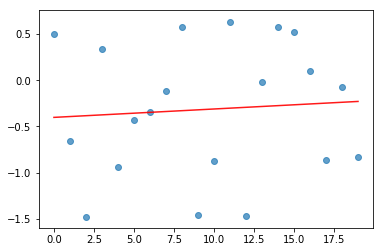

In [8]:
# Draw observations from normal distribution
np.random.seed(107) # Fix seed for random number generation
rand = np.random.randn(20)

# Conduct linear regression on the ordered list of observations
xs = np.arange(20)
a, b = linreg(xs, rand)
print ('Slope:', b, 'Intercept:', a)

# Plot the raw data and the regression line
plt.scatter(xs, rand, alpha=0.7)
Y_hat = xs * b + a
plt.plot(xs, Y_hat, 'r', alpha=0.9);

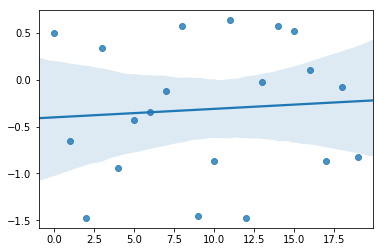

In [9]:
import seaborn as sns

sns.regplot(xs, rand);

Slope: -0.000569342363105334 Intercept: 0.009011767319021813


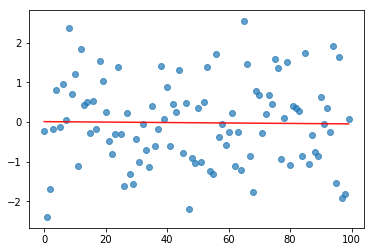

In [10]:
# Draw more observations
rand2 = np.random.randn(100)

# Conduct linear regression on the ordered list of observations
xs2 = np.arange(100)
a2, b2 = linreg(xs2, rand2)
print ('Slope:', b2, 'Intercept:', a2)

# Plot the raw data and the regression line
plt.scatter(xs2, rand2, alpha=0.7)
Y_hat2 = xs2 * b2 + a2
plt.plot(xs2, Y_hat2, 'r', alpha=0.9);

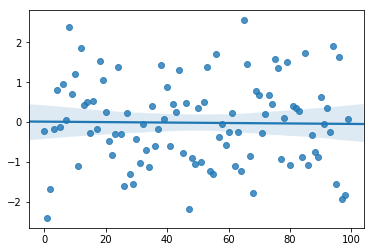

In [11]:
sns.regplot(xs2, rand2);

# Regime changes

A regime change (or structural break) is when something changes in the process generating the data, causing future samples to follow a different distribution. 

The regression analysis assumes that the errors are uncorrelated and have constant variance, which is often not be the case if there is a regime change.

In [16]:
import fix_yahoo_finance as yf
from datetime import datetime
start="2003-01-01"
end = '2009-02-01'
#end=datetime.now().strftime ("%Y-%m-%d")

[*********************100%***********************]  1 of 1 downloaded


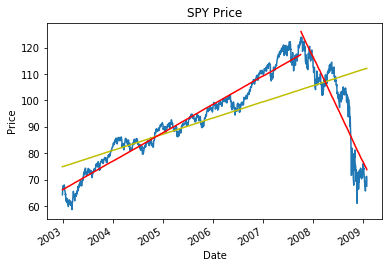

In [19]:
SPY = yf.download('SPY', start=start, end=end)
pricing = SPY['Adj Close']

# Manually set the point where we think a structural break occurs
breakpoint = 1200
xs = np.arange(len(pricing))
xs2 = np.arange(breakpoint)
xs3 = np.arange(len(pricing) - breakpoint)

# Perform linear regressions on the full data set, the data up to the breakpoint, and the data after
a, b = linreg(xs, pricing)
a2, b2 = linreg(xs2, pricing[:breakpoint])
a3, b3 = linreg(xs3, pricing[breakpoint:])

Y_hat = pd.Series(xs * b + a, index=pricing.index)
Y_hat2 = pd.Series(xs2 * b2 + a2, index=pricing.index[:breakpoint])
Y_hat3 = pd.Series(xs3 * b3 + a3, index=pricing.index[breakpoint:])

# Plot the raw data
pricing.plot()
Y_hat.plot(color='y')
Y_hat2.plot(color='r')
Y_hat3.plot(color='r')
plt.title('SPY Price')
plt.ylabel('Price');

Below we use a test from `statsmodels` which computes the probability of observing the data if there were no breakpoint.

In [20]:
stats.diagnostic.breaks_cusumolsresid(
    regression.linear_model.OLS(pricing, sm.add_constant(xs)).fit().resid)[1]

7.823230542379562e-59

## Multicollinearity

Below, we run a multiple linear regression in which the independent variables are highly correlated. 

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
Constant: -16.705519835665296 MLR beta to S&P 500: 0.2982354843973645  MLR beta to MDY 0.07068921497375964


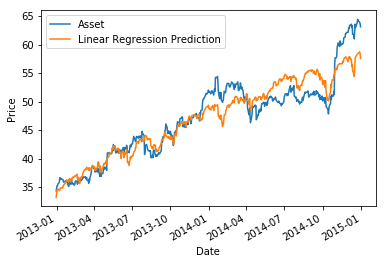

In [21]:
# Get pricing data for two benchmarks (stock indices) and a stock
start = '2013-01-01'
end = '2015-01-01'
b1 = yf.download('SPY', start=start, end=end)['Adj Close']
b2 = yf.download('MDY', start=start, end=end)['Adj Close']
asset = yf.download('V', start=start, end=end)['Adj Close']

mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print ('Constant:', mlr.params[0], 'MLR beta to S&P 500:', mlr.params[1], ' MLR beta to MDY', mlr.params[2])

# Plot the asset pricing data and the regression model prediction, just for fun
asset.plot()
prediction.plot();
plt.ylabel('Price')
plt.legend(['Asset', 'Linear Regression Prediction']);

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
Constant: -28.327575379360674 MLR beta to S&P 500: 0.24610431467804056  MLR beta to MDY 0.16439333595151218


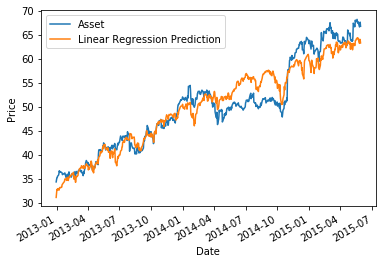

In [22]:
# Get pricing data for two benchmarks (stock indices) and a stock
start = '2013-01-01'
end = '2015-06-01'
b1 = yf.download('SPY', start=start, end=end)['Adj Close']
b2 = yf.download('MDY', start=start, end=end)['Adj Close']
asset = yf.download('V', start=start, end=end)['Adj Close']

mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print ('Constant:', mlr.params[0], 'MLR beta to S&P 500:', mlr.params[1], ' MLR beta to MDY', mlr.params[2])

# Plot the asset pricing data and the regression model prediction, just for fun
asset.plot()
prediction.plot();
plt.ylabel('Price')
plt.legend(['Asset', 'Linear Regression Prediction']);

We can check that our independent variables are correlated by computing their correlation coefficient. 

In [23]:
# Compute Pearson correlation coefficient
sp.stats.pearsonr(b1,b2)[0] # Second return value is p-value

0.9898236078446015